## Importing libraries


In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
import re
import nltk
from bs4 import BeautifulSoup
from nltk.tag import pos_tag
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

## Downloading the data

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"basilkjose","key":"debf1aec3383fe1a6ae788e9b221f03a"}'}

In [3]:
!mkdir -p ~/.kaggle # reading the data using kaggle api
!cp kaggle.json ~/.kaggle/

In [4]:
!kaggle competitions download -c word2vec-nlp-tutorial

 69% 9.00M/13.0M [00:00<00:00, 15.7MB/s]
100% 13.0M/13.0M [00:00<00:00, 20.4MB/s]
  0% 0.00/276k [00:00<?, ?B/s]
100% 276k/276k [00:00<00:00, 126MB/s]
 40% 5.00M/12.6M [00:00<00:01, 7.09MB/s]
100% 12.6M/12.6M [00:00<00:00, 16.2MB/s]
 35% 9.00M/26.0M [00:00<00:01, 11.6MB/s]
100% 26.0M/26.0M [00:00<00:00, 31.4MB/s]


In [5]:
!unzip \*.zip  && rm *.zip #unzipping

Archive:  unlabeledTrainData.tsv.zip
  inflating: unlabeledTrainData.tsv  

Archive:  testData.tsv.zip
  inflating: testData.tsv            

Archive:  labeledTrainData.tsv.zip
  inflating: labeledTrainData.tsv    

3 archives were successfully processed.


## Reading the data

In [6]:
data = pd.read_csv("/content/labeledTrainData.tsv", header=0, \
                    delimiter="\t", quoting=3)

In [7]:
data.drop('id',inplace=True,axis=1)
data_copy=data.copy(deep=True)
data.head()

,sentiment,review
0,1,"""With all this stuff going down at the moment ..."
1,1,"""\""The Classic War of the Worlds\"" by Timothy ..."
2,0,"""The film starts with a manager (Nicholas Bell..."
3,0,"""It must be assumed that those who praised thi..."
4,1,"""Superbly trashy and wondrously unpretentious ..."


In [8]:
print('-----SHAPE OF THE DATASET-----')
data.shape

-----SHAPE OF THE DATASET-----


(25000, 2)

In [9]:
print('-----DISTRIBUTION OF DATASET-----')
data['sentiment'].value_counts()

-----DISTRIBUTION OF DATASET-----


1    12500
0    12500
Name: sentiment, dtype: int64

### Nan/Null Value and Duplicate Checks

In [10]:
print("We have {} NaN/Null values in dataset ".format(data.isnull().values.sum()))
print("Number of duplicate in  dataset : {} ".format(sum(data['review'].duplicated())))

We have 0 NaN/Null values in dataset 
Number of duplicate in  dataset : 96 


In [11]:
#removing duplicate rows
print('REMOVING DUPLICATE ROWS....')
data=data.drop_duplicates(subset={'review'}, keep='first', inplace=False)
data.shape

REMOVING DUPLICATE ROWS....


(24904, 2)

In [12]:
# printing some random reviews
print('------PRINTING SOME RANDOM REVIEWS-----')
print('\n')
sent_0 = data['review'].values[0]
print(sent_0)

print("="*200)

sent_1000 = data['review'].values[1000]
print(sent_1000)
print("="*200)

sent_1500 = data['review'].values[1500]
print(sent_1500)
print("="*200)

sent_4900 = data['review'].values[4900]
print(sent_4900)
print("="*200)

------PRINTING SOME RANDOM REVIEWS-----


"With all this stuff going down at the moment with MJ i've started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ's feeling towards the press and also the obvious message of drugs are bad m'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring. Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him.<br /><br />The a

* From the above samples of data we can understand ,it is mandatory to clean the data

## Data Preprocessing

### Removing all urls from data

In [13]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

"With all this stuff going down at the moment with MJ i've started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ's feeling towards the press and also the obvious message of drugs are bad m'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring. Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him.<br /><br />The actual feature film bit when it finally sta

### Removing all tags from data

In [14]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*200)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*200)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*200)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

"With all this stuff going down at the moment with MJ i've started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ's feeling towards the press and also the obvious message of drugs are bad m'kay.Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring. Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him.The actual feature film bit when it finally starts is only on for 20 mi

### Decontracting the words

In [15]:
# https://stackoverflow.com/a/47091490/4084039

def decontracted(phrase):
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

### Removing words with numbers from data

In [16]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

"With all this stuff going down at the moment with MJ i've started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ's feeling towards the press and also the obvious message of drugs are bad m'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring. Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him.<br /><br />The actual feature film bit when it finally sta

### Removing special character from data

In [17]:
#remove special character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

 Deathtrap runs like a play within a movie about who did what to whom as it primarily takes place on one set The premise is that an accomplished playwright whose star is falling receives a magnificent manuscript from a former student and so he plans to off his protege and appropriate his play to the loud protests of his wife Or so you think for the first half of the movie Past the halfway mark Deathtrap begins to throw in twists and surprises that turn its premise on its head then right around and then in a mad spin all the time keeping its title appropriate It s an excellent mystery movie soaked in wit br br Michael Caine as the senior playwright plays himself in this movie a slightly loony and very dramatic Brit No surprises here he does his usual good work He gets the best line of Deathtrap which he executes perfectly What is your definition of success being gang banged in a state penitentiary br br Christopher Reeve on the other hand juggles comedy and drama in a surprisingly stron

In [21]:
nltk.download('stopwords')
eng_stopwords = set(stopwords.words('english'))
def cleaning(data):
  preprocessed_reviews = []
  for sentance in tqdm(data['review'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in eng_stopwords)# removing stopwords and 
                                                                                           #converting into lower case
    preprocessed_reviews.append(sentance.strip())
  data['review']=preprocessed_reviews
  return data


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [23]:
data_after_cleaning=cleaning(data) #dataframe after cleaning
data_after_cleaning.to_csv('after_cleaning.csv')# saving csv file after cleaning

100%|██████████| 24904/24904 [00:19<00:00, 1288.54it/s]


In [24]:
print('-----DATA BEFORE CLEANING-----')
print('\n')
print(data_copy['review'][9])
print('\n')
print(data_copy['review'][100])
print('\n')
print('-----DATA AFTER CLEANING-----')
print('\n')
print(data_after_cleaning['review'][9])
print('\n')
print(data_after_cleaning['review'][100])

-----DATA BEFORE CLEANING-----


"<br /><br />This movie is full of references. Like \"Mad Max II\", \"The wild one\" and many others. The ladybug´s face it´s a clear reference (or tribute) to Peter Lorre. This movie is a masterpiece. We´ll talk much more about in the future."


"There is a uk edition to this show which is rather less extravagant than the US version. The person concerned will get a new kitchen or perhaps bedroom and bathroom and is wonderfully grateful for what they have got. The US version of this show is everything that reality TV shouldn't be. Instead of making a few improvements to a house which the occupants could not afford or do themselves the entire house gets rebuilt. I do not know if this show is trying to show what a lousy welfare system exists in the US or if you beg hard enough you will receive. The rather vulgar product placement that takes place, particularly by Sears, is also uncalled for. Rsther than turning one family in a deprived area into potential

###  Stemming

In [ ]:
def stemmer(data):
  review_clean_ps = []
  ps = PorterStemmer()
  for sentance in tqdm(data['review'].values):
    ps_stems = []
    for w in sentance.split():
      if w == 'oed':
        continue
      ps_stems.append(ps.stem(w))  
     
    review_clean_ps.append(' '.join(ps_stems))   
  data['review']=review_clean_ps
  return data

In [ ]:
data_stemmer=stemmer(data_after_cleaning)

100%|██████████| 24904/24904 [01:07<00:00, 371.57it/s]


In [ ]:
def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return 'n'

###  Lemmatizing

In [ ]:
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

def lemmatization(data):
  review_clean_wnl = []
  wnl = WordNetLemmatizer()
  for sentance in tqdm(data['review'].values):
     wnl_stems = []
     token_tag = pos_tag(sentance.split())
     for pair in token_tag:
       res = wnl.lemmatize(pair[0],pos=get_wordnet_pos(pair[1]))
       wnl_stems.append(res)
     review_clean_wnl.append(' '.join(wnl_stems))
  data['review']=review_clean_wnl
  return data


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
data_lemma=lemmatization(data_stemmer)

100%|██████████| 24904/24904 [03:12<00:00, 129.54it/s]


In [ ]:
print('-----DATA AFTER  STEMMING AND LEMMATIZATION-----')
print('\n')
print(data_lemma['review'][9])
print('\n')
print(data_lemma['review'][100])

-----DATA AFTER  STEMMING AND LEMMATIZATION-----


movi full refer like mad max ii wild one mani other ladybug face clear refer tribut peter lorr movi masterpiec talk much futur


uk edit show rather less extravag u version person concern get new kitchen perhap bedroom bathroom wonder grate get u version show everyth realiti tv instead make improv hous occup could afford entir hous get rebuild know show tri show lousi welfar system exist u beg hard enough receiv rather vulgar product placement take place particularli sear also uncal rsther turn one famili depriv area potenti millionair would far good help commun whole instead spend hundr thousand dollar one home build someth whole commun perhap place diy power tool borrow return along build materi everyon benefit want give one person caus enorm resent among rest local commun still live run hous


## Featurization of data

In [25]:
data_model=pd.read_csv("/content/after_cleaning.csv")#Loading the saved csv file after cleaned data

* For Machine Learning modelling we are not using stemming and lemmatization because it take more time to process while deploying

In [26]:
data_model.head()

,Unnamed: 0,sentiment,review
0,0,1,stuff going moment mj started listening music ...
1,1,1,classic war worlds timothy hines entertaining ...
2,2,0,film starts manager nicholas bell giving welco...
3,3,0,must assumed praised film greatest filmed oper...
4,4,1,superbly trashy wondrously unpretentious explo...


In [27]:
X=data_model['review']
Y=data['sentiment']
print(X.shape)
print(Y.shape)

(24904,)
(24904,)


In [28]:
# splitting into train and test dataset
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25,random_state=42)
print('TRAIN DATA - ',X_train.shape)
print('\n')
print('TEST DATA - ',X_test.shape)

TRAIN DATA -  (18678,)


TEST DATA -  (6226,)


For text data Featurization we can use different types of techniques, here we use mainly 2 types
* Bag of words(with ngrams)
* Tf-Idf


### Bag of words

In [ ]:
#bag of words
vectorizer_bow = CountVectorizer(min_df=10,ngram_range=(1,4), max_features=5000)
vectorizer_bow.fit(X_train.values)  #fitting
x_train_bow= vectorizer_bow.transform(X_train.values) 
x_test_bow= vectorizer_bow.transform(X_test.values)

print("After vectorizations")
print(x_train_bow.shape, y_train.shape)
print(x_test_bow.shape, y_test.shape)
print("="*40)

After vectorizations
(18678, 5000) (18678,)
(6226, 5000) (6226,)


### Tf-Idf

In [29]:
#tfidf
tfidfvectorizer = TfidfVectorizer(min_df=10,max_features=5000)
text_tfidf = tfidfvectorizer.fit(X_train.values) #fitting

X_train_tfidf =tfidfvectorizer.transform(X_train.values) 
X_test_tfidf =tfidfvectorizer.transform(X_test.values)

print("After vectorizations")
print(X_train_tfidf.shape, y_train.shape)
print(X_test_tfidf.shape, y_test.shape)
print("="*40)

After vectorizations
(18678, 5000) (18678,)
(6226, 5000) (6226,)


## Modeling

* For modelling we use only tf-idf vectorized data only.

### Logistic Regression

In [ ]:
c_space = np.logspace(-5, 8, 15)
param_grid = {'C': c_space}
logreg = LogisticRegression()
  
logreg_cv = GridSearchCV(logreg, param_grid, cv = 5)# hyper parameter tuning
  
logreg_cv.fit(X_train_tfidf,  y_train)
  
print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_)) 
print("Best score is {}".format(logreg_cv.best_score_))

Tuned Logistic Regression Parameters: {'C': 3.727593720314938}
Best score is 0.881519081321718


In [ ]:
lr= LogisticRegression(C= 3.727593720314938)
lr.fit(X_train_tfidf,  y_train)

LogisticRegression(C=3.727593720314938, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
print("Accuracy: ",(accuracy_score(y_test,lr.predict(X_test_tfidf))))

Accuracy:  0.8803405075489881


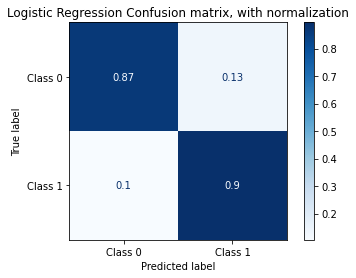

In [ ]:
disp = metrics.plot_confusion_matrix(lr,X_test_tfidf, y_test,
                                 display_labels=['Class 0', 'Class 1'],
                                 cmap=plt.cm.Blues,
                                 normalize='true')
disp.ax_.set_title('Logistic Regression Confusion matrix, with normalization');

### Support Vector Machine

In [ ]:
param_grid = {'C': [0.1, 1, .01 ], 
              'gamma': [1, 0.1, 0.01],
              'kernel': ['rbf']}     # hyper parameter tuning
  
svm = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3,cv=2)
  
svm.fit(X_train_tfidf, y_train)

print(svm.best_params_)
print(svm.best_estimator_)

Fitting 2 folds for each of 9 candidates, totalling 18 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.803, total= 2.2min
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.2min remaining:    0.0s


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.795, total= 2.2min
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  4.5min remaining:    0.0s


[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.745, total= 2.3min
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.720, total= 2.4min
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................
[CV] ....... C=0.1, gamma=0.01, kernel=rbf, score=0.500, total= 2.4min
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................
[CV] ....... C=0.1, gamma=0.01, kernel=rbf, score=0.500, total= 2.4min
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV] ............ C=1, gamma=1, kernel=rbf, score=0.876, total= 1.8min
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV] ............ C=1, gamma=1, kernel=rbf, score=0.879, total= 1.8min
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[CV] .......... C=1, gamma=0.1, kernel=rbf, score=0.866, total= 1.7min
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[CV] .

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed: 39.8min finished


{'C': 1, 'gamma': 1, 'kernel': 'rbf'}
SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf', max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False)


In [30]:
svm=SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
svm.fit(X_train_tfidf, y_train)

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf', max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [31]:
print("Accuracy: ",(accuracy_score(y_test,svm.predict(X_test_tfidf))))

Accuracy:  0.8861227112110505


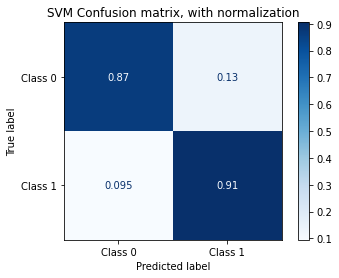

In [32]:
disp = metrics.plot_confusion_matrix(svm,X_test_tfidf, y_test,
                                 display_labels=['Class 0', 'Class 1'],
                                 cmap=plt.cm.Blues,
                                 normalize='true')
disp.ax_.set_title('SVM Confusion matrix, with normalization');

### Naive Bayes classifier 

In [ ]:
navie=MultinomialNB(class_prior=[0.5,0.5])
param_grid={'alpha': [ 0.01, 0.1, 1, 10,0.001]} # hyper parameter tuning
navie_clf=GridSearchCV(navie,param_grid, verbose = 2,cv=2)
navie_clf.fit(X_train_tfidf, y_train)

Fitting 2 folds for each of 5 candidates, totalling 10 fits
[CV] alpha=0.01 ......................................................
[CV] ....................................... alpha=0.01, total=   0.0s
[CV] alpha=0.01 ......................................................
[CV] ....................................... alpha=0.01, total=   0.0s
[CV] alpha=0.1 .......................................................
[CV] ........................................ alpha=0.1, total=   0.0s
[CV] alpha=0.1 .......................................................
[CV] ........................................ alpha=0.1, total=   0.0s
[CV] alpha=1 .........................................................
[CV] .......................................... alpha=1, total=   0.0s
[CV] alpha=1 .........................................................
[CV] .......................................... alpha=1, total=   0.0s
[CV] alpha=10 ........................................................
[CV] ............

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ...................................... alpha=0.001, total=   0.0s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished


GridSearchCV(cv=2, error_score=nan,
             estimator=MultinomialNB(alpha=1.0, class_prior=[0.5, 0.5],
                                     fit_prior=True),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [0.01, 0.1, 1, 10, 0.001]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=2)

In [ ]:
print(navie_clf.best_params_)
print(navie_clf.best_estimator_)

{'alpha': 1}
MultinomialNB(alpha=1, class_prior=[0.5, 0.5], fit_prior=True)


In [33]:
navie_clf=MultinomialNB(alpha=1, class_prior=[0.5, 0.5], fit_prior=True)
navie_clf.fit(X_train_tfidf, y_train)

MultinomialNB(alpha=1, class_prior=[0.5, 0.5], fit_prior=True)

In [36]:
print("Accuracy: ",(accuracy_score(y_test,navie_clf.predict(X_test_tfidf))))

Accuracy:  0.8522325730806296


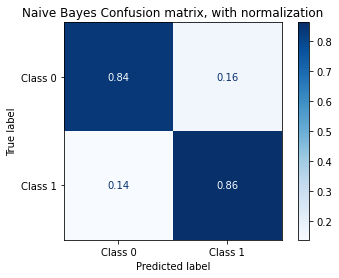

In [37]:
disp = metrics.plot_confusion_matrix(navie_clf,X_test_tfidf, y_test,
                                 display_labels=['Class 0', 'Class 1'],
                                 cmap=plt.cm.Blues,
                                 normalize='true')
disp.ax_.set_title('Naive Bayes Confusion matrix, with normalization');

In [1]:
from prettytable import PrettyTable
myTable = PrettyTable(["SL.NO", "MODEL", "TEST ACCURACY"])
myTable.add_row(["1", "LOGISTIC REGRESSION", "88.03"])
myTable.add_row(["2", "NAIVE BAYES", "85.22"])
myTable.add_row(["3", "SUPPORT VECTOR MACHINE", "88.61"])

In [2]:
print(myTable)

+-------+------------------------+---------------+
| SL.NO |         MODEL          | TEST ACCURACY |
+-------+------------------------+---------------+
|   1   |  LOGISTIC REGRESSION   |     88.03     |
|   2   |      NAIVE BAYES       |     85.22     |
|   3   | SUPPORT VECTOR MACHINE |     88.61     |
+-------+------------------------+---------------+


## TO DO


* Try to use other encoding techniques like Bag of words and word2vec for featurization.
* For modeling use data after stemming and lemmatization.
* Done more hyperparameter tuning.
* Use deep learning techniques like rnn and lstm.